In [29]:
import os
import sys
import cv2
import numpy as np
import glob
import math
import matplotlib.pyplot as plt

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

# 1. Create Tracking Class

In [ ]:
class CentroidTracker4():
    def __init__(self, net, class_names, preprocess, maxDisappeared=16):
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.maxDisappeared = maxDisappeared
        self.totalObjects = 0
        self.class_counts = { }  
        self.class_names = class_names
        self.prevObj = None
        
        self.preprocess = preprocess
        self.net = net
        self.net.eval()
    
    def register(self, centroid, object_class):
        self.objects[self.nextObjectID] = (centroid, object_class)  
        self.disappeared[self.nextObjectID] = 0
        self.totalObjects += 1
        
        if object_class in self.class_counts:
            self.class_counts[object_class] += 1
        else:
            self.class_counts[object_class] = 1
        self.nextObjectID += 1
        
    def deregister(self, objectID):
        _, object_class = self.objects[objectID]
        self.prevObj = object_class
        del self.objects[objectID]
        del self.disappeared[objectID]
        
    
    def update(self, centroid_lst, ob_img):
        if len(centroid_lst) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            return self.objects

        inputCentroids = np.array(centroid_lst)
        
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i], self.predict(ob_img[i]))
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = [item[0] for item in self.objects.values()]
            max_y_existing = max([centroid[1] for centroid in objectCentroids])
            filteredInputCentroids = []
            filteredObImg = []

            for i, centroid in enumerate(inputCentroids):
                if centroid[1] < max_y_existing + 160: 
                    filteredInputCentroids.append(centroid)
                    filteredObImg.append(ob_img[i])
                else:
                    self.register(centroid,self.predict(ob_img[i]))
            
            filteredInputCentroids = np.array(filteredInputCentroids)

            if len(filteredInputCentroids) == 0:
                for objectID in list(self.disappeared.keys()):
                    self.disappeared[objectID] += 1
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
                return self.objects

            D = dist.cdist(np.array(objectCentroids), filteredInputCentroids)

            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue
                objectID = objectIDs[row]
                _, object_class_current = self.objects[objectID]
                self.objects[objectID] = (filteredInputCentroids[col], object_class_current)
                self.disappeared[objectID] = 0
                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            if D.shape[0] >= D.shape[1]:
                for row in unusedRows:
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            else:
                for col in unusedCols:
                    self.register(filteredInputCentroids[col], self.predict(filteredObImg[col]))

        return self.objects

    def delete_all_objects(self):
        self.objects.clear()
        self.disappeared.clear()
        self.nextObjectID = 0
        self.class_counts.clear()
        self.prevObj = None
    
    def draw_class_count_table(self, frame):
        x, y = 0, 20
        width, height = 550, 500  
        padding = 10

        info_x, info_y = x, y + height + 20
        info_width, info_height = 550, 100  

    
        frame[y:y + height, x:x + width] = (255, 255, 200)
        cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 0, 0), 2)

        cv2.putText(frame, "Class Count", (x + 10, y + 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)

        row_height = 40
        for i, (object_class, count) in enumerate(self.class_counts.items()):
            text = f"{object_class}: {count}"
            cv2.putText(frame, text, (x + 10, y + 80 + i * row_height), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

        frame[info_y:info_y + info_height, info_x:info_x + info_width] = (240, 240, 255)
        cv2.rectangle(frame, (info_x, info_y), (info_x + info_width, info_y + info_height), (0, 0, 0), 2)

        if self.objects:
            current_object = next(iter(self.objects.values()))  # Lấy đối tượng đầu tiên trong self.objects
            _, current_object_class = current_object
            text_current_object = f"Current Obj: {current_object_class}"
            cv2.putText(frame, text_current_object, (info_x + 10, info_y + 80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        if self.prevObj:
            text_prev_object = f"Prev Obj: {self.prevObj}"
            cv2.putText(frame, text_prev_object, (info_x + 10, info_y + 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

        return frame

    def predict(self, input):
        input_rgb = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        input_image = Image.fromarray(input_rgb)
        input_tensor = self.preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
        with torch.no_grad():
            output = self.net(input_batch)

            # Get the predicted class
            _, predicted_class = output.max(1)
        return self.class_names[predicted_class.item()]

# 2. Load model and create Traker

In [35]:
model_sq = models.squeezenet1_1(pretrained=True)


model_sq.classifier[1] = torch.nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))

model_sq.load_state_dict(torch.load('Model_mnpj/sqnet_10class_mnpj.pth', map_location=torch.device('cpu'), weights_only=True))
class_names = ['dilah','g7','jackjill','karo','nesteaatiso','nesteachanh','nesteahoaqua','orion','tipo','y40']  

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

tracker3 = CentroidTracker4(model_sq, class_names, preprocess, maxDisappeared=3)

# 3. Preprocess

In [38]:
videopath = r'video_test_1.avi'

tracker3.delete_all_objects()

cap = cv2.VideoCapture(videopath)

fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=False)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
scale_ratio = 8

#Define Threshold Area
min_area = frame_width*frame_height*0.05/scale_ratio/scale_ratio
max_area = frame_width*frame_height*0.8/scale_ratio/scale_ratio

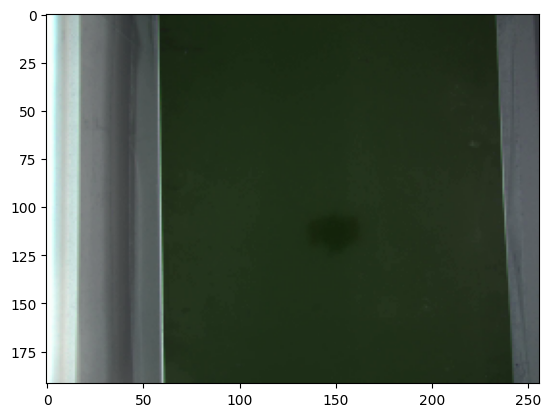

In [23]:
first_frame =True
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if first_frame:
        resized_fr = cv2.resize(frame, (0, 0), fx=1/scale_ratio, fy=1/scale_ratio, interpolation=cv2.INTER_AREA)

        plt.imshow(resized_fr)
        plt.show()
        first_frame = False

### Define margin

In [40]:
left_margin = 50
right_margin = 240
bottom_margin = 175

# 4. Create Output

In [42]:
cap = cv2.VideoCapture(videopath)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Thiết lập VideoWriter để lưu file video đầu ra
out = cv2.VideoWriter('output_Detect_Tr4.avi', cv2.VideoWriter_fourcc(*'MJPG'), 30, (frame_width, frame_height), isColor=True)

if not cap.isOpened():
    print("Không thể mở video. Kiểm tra đường dẫn!")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    resized_fr = cv2.resize(frame, (0, 0), fx=1/scale_ratio, fy=1/scale_ratio, interpolation=cv2.INTER_AREA)
    
    # Áp dụng Gaussian blur trực tiếp lên ảnh RGB
    frame_blur = cv2.GaussianBlur(resized_fr, (7, 7), 0)
    frame_blur[:,:left_margin,:]=0
    frame_blur[:,right_margin:,:]=0
    
    # Áp dụng bộ trích nền
    fgmask = fgbg.apply(frame_blur)
    
    eroded_fr= cv2.erode(fgmask, kernel, iterations=1)
    
    
    contours, _ = cv2.findContours(eroded_fr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroid_accept = []
    objects = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h

        if (area > min_area) and (area < max_area):
            if y + h> bottom_margin:
                continue
            x_c = x*scale_ratio
            y_c = y*scale_ratio
            w_c = w*scale_ratio
            h_c = h*scale_ratio
            centroid_accept.append(((x_c+w_c/2),(y_c+h_c/2)))
            cv2.rectangle(frame, (x_c, y_c), (x_c + w_c, y_c + h_c), (0, 255, 0), 2)
            
            img_out = frame[y_c:y_c+h_c, x_c:x_c+w_c]
            objects.append(img_out)
            
    tracker3.update(centroid_accept,objects)
    
    frame_cpl = tracker3.draw_class_count_table(frame)
    out.write(frame_cpl)

# Giải phóng tài nguyên
out.release()
cap.release()